In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import math

In [2]:
mnist = fetch_openml('mnist_784', version = 1)

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
sss = StratifiedShuffleSplit(n_splits = 1, train_size=10000, test_size=1000)

In [5]:
for train_index, test_index in sss.split(mnist.data, mnist.target):
  X_train = mnist.data.iloc[train_index] 
  y_train = mnist.target[train_index]
  X_test = mnist.data.iloc[test_index] 
  y_test = mnist.target[test_index]

In [6]:
print(X_train.shape, y_test.shape)

(10000, 784) (1000,)


In [7]:
import matplotlib.pyplot as plt

In [8]:
def clip_image(img, clipping_size = 0):
  img = img.reshape((28, 28))
  img = np.delete(img, range(clipping_size), 0)
  img = np.delete(img, range(clipping_size), 1)
  return img.flatten()

In [9]:
def momentum(img, step_size, n_steps, clipping_size):
  img = img.reshape((28 - clipping_size, 28-clipping_size))
  momentums = []
  for i in range(n_steps):
    x = np.array(list(range(i*step_size, (i+1)*step_size)))
    for j in range(n_steps):
      pixels = img[j*step_size: (j+1)*step_size, i*step_size: (i+1) * step_size]
      y =  np.array(list(range(j*step_size, (j+1)*step_size))).reshape(step_size,1)
      area = np.sum(np.sum(pixels))
      x_c = np.sum(np.sum(x.T * pixels)) / (area + 1e-10)
      y_c = np.sum(np.sum(y * pixels)) / (area + 1e-10)
      momentums.append((x_c, y_c))
  return momentums

In [10]:
def reduction(data = None, n_momentums = 9):
  n_steps = math.floor(np.sqrt(n_momentums))
  clipping_size = 28 % n_steps
  step_size = (28 - clipping_size) // n_steps
  data = np.apply_along_axis(clipping_size = clipping_size
                      , func1d = clip_image, axis = 1, arr = data)
  momentums = np.apply_along_axis(step_size = step_size, n_steps = n_steps,
                                  clipping_size= clipping_size,
                                  func1d = momentum, axis = 1, arr = data)
  return data, momentums

In [11]:
data, momentums = reduction(np.array(X_train.copy()), n_momentums = 9)

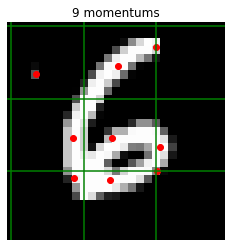

In [12]:
img_num = 4569
plt.imshow(np.array(data[img_num]).reshape((27, 27)), cmap='gray'
            , vmin = 0, vmax = 255)
plt.scatter(momentums[img_num, :, 0], momentums[img_num, :, 1], color = 'red')
eq = list(range(0, 27, 9))
for i in eq:
  plt.axvline(x=i, color ='green')
  plt.axhline(y=i, color = 'green')
plt.axis('off')
plt.title('9 momentums')
plt.show()
plt.savefig('196m.png', bbox_inches='tight')

In [13]:
from scipy import stats
from sklearn.base import ClassifierMixin

In [14]:
class KNearstNeighbors(ClassifierMixin):
  def __init__(self, k = 8):
    self.k = k
  def fit(self, X, y):
    self.X = X
    self.y = y
  def predict_(self, X):
    distances = np.sum((self.X - X) ** 2, axis = 1)
    sorted_distances = np.argsort(distances)
    return stats.mode(self.y.iloc[sorted_distances[:self.k]]).mode[0]
  def predict(self, X):
    if(len(X.shape) == 2):
      return np.apply_along_axis(self.predict_, axis = 1, arr = X)
    else:
      return self.predict_(X)

In [15]:
knn = KNearstNeighbors()

In [16]:
X_train_m = reduction(np.array(X_train.copy()), n_momentums = 9)[1].reshape(10000, 18)
X_test_m = reduction(np.array(X_test.copy()), n_momentums = 9)[1].reshape(1000, 18)

In [17]:
knn.fit(X_train_m, y_train)

In [18]:
print(knn.score(X_train_m, y_train))

0.8769


In [19]:
print(knn.score(X_test_m, y_test))

0.864


In [20]:
best_scores = [0]
x = [i * i for i in range(29)]

In [ ]:
for i in range(1, 29):
  n_mom = i * i
  X_train_m = reduction(X_train.copy(), n_mom)[1]
  knn = KNearstNeighbors(k=8)
  knn.fit(X_train_m.reshape((10000, n_mom * 2)), y_train)
  X_test_m = reduction(X_test.copy(), n_mom)[1]
  best_scores.append(knn.score(X_test_m.reshape((1000, n_mom * 2)), y_test))

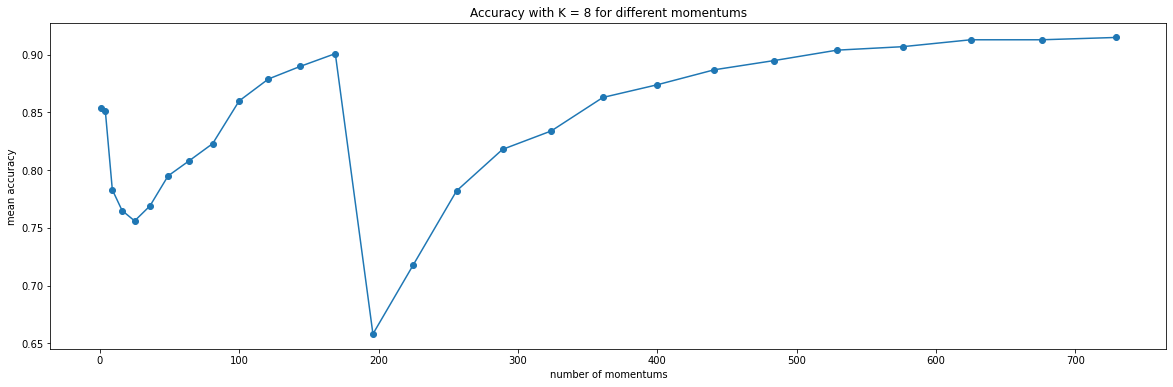

In [ ]:
plt.figure(figsize = (20, 6))
plt.plot(x[1:], best_scores[1:])
plt.scatter(x[1:], best_scores[1:])
plt.title('Accuracy with K = 8 for different momentums')
plt.xlabel('number of momentums')
plt.ylabel('mean accuracy')
plt.savefig('acc3.png', bbox_inches='tight')
plt.show()